In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# Load the CSV
df = pd.read_csv("date_colesterol.csv")
x = df["Ore_Exercitii"].values
y = df["Colesterol"].values


In [2]:
def build_mixture_model_fixed(x, y, K):
    with pm.Model() as model:
        w = pm.Dirichlet("w", a=np.ones(K))
        
        alpha = pm.Normal("alpha", mu=200, sigma=50, shape=K)
        beta  = pm.Normal("beta", mu=0, sigma=20, shape=K)
        gamma = pm.Normal("gamma", mu=0, sigma=5, shape=K)
        
        sigma = pm.HalfNormal("sigma", sigma=20, shape=K)
        
        comp_dists = []
        for k in range(K):
            mu_k = alpha[k] + beta[k]*x + gamma[k]*x**2
            comp_dists.append(pm.Normal.dist(mu=mu_k, sigma=sigma[k]))
        
        y_obs = pm.Mixture("y_obs", w=w, comp_dists=comp_dists, observed=y)
        
    return model


In [3]:
traces = {}
for K in [3, 4, 5]:
    model = build_mixture_model_fixed(x, y, K)
    with model:
        trace = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=42, idata_kwargs={"log_likelihood": True})
        traces[K] = trace


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 389 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 658 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
for K, trace in traces.items():
    print(f"\n=== K = {K} ===")
    w_mean = trace.posterior['w'].mean(dim=["chain","draw"]).values
    alpha_mean = trace.posterior['alpha'].mean(dim=["chain","draw"]).values
    beta_mean  = trace.posterior['beta'].mean(dim=["chain","draw"]).values
    gamma_mean = trace.posterior['gamma'].mean(dim=["chain","draw"]).values
    sigma_mean = trace.posterior['sigma'].mean(dim=["chain","draw"]).values
    
    print("Weights:", w_mean)
    print("Alpha:", alpha_mean)
    print("Beta:", beta_mean)
    print("Gamma:", gamma_mean)
    print("Sigma:", sigma_mean)



=== K = 3 ===
Weights: [0.3397961  0.32390465 0.33629925]
Alpha: [218.970826   230.82246764 223.80546053]
Beta: [-5.41449895 -5.79065965 -4.61278508]
Gamma: [0.20708459 0.12895782 0.20581305]
Sigma: [5.47276552 6.62929963 5.833426  ]

=== K = 4 ===
Weights: [0.30409682 0.25773418 0.26021119 0.17795781]
Alpha: [221.88804362 241.35762279 214.68981737 217.58925304]
Beta: [-4.14484299 -7.19910482 -3.8603398  -3.30156508]
Gamma: [ 0.06565072  0.43938826 -0.01629391 -0.15261084]
Sigma: [5.77690407 5.54767865 5.88964091 7.33173073]

=== K = 5 ===
Weights: [0.26470778 0.23344392 0.17286607 0.15486856 0.17411367]
Alpha: [229.72660462 217.69405114 218.54732117 229.78293967 216.18633514]
Beta: [-6.22155548 -3.26323275 -2.0198768  -1.28038041 -4.4660884 ]
Gamma: [ 0.30802344  0.01388966 -0.50229366  0.55525401  0.48166396]
Sigma: [ 5.32036786  5.82209183 10.4819993   8.61473642  7.46591573]


In [ ]:
model_dict = {K: traces[K] for K in [3,4,5]}
loo_dict = {}
waic_dict = {}

for K, trace in traces.items():
    loo_dict[K] = az.loo(trace, pointwise=True)
    waic_dict[K] = az.waic(trace, pointwise=True)

az.compare({f"K={K}": traces[K] for K in [3,4,5]}, ic="loo")
az.compare({f"K={K}": traces[K] for K in [3,4,5]}, ic="waic")


# Acum am rulat cu samples = 2000
# Din cate se poate vedea, se pare ca k=5 clusterizeaza cel mai bine datele, dar totusi are niste warninguri legate de isntabilitate numerica, deci si k=4 poate fi o varianta safe


/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
K=5,0,-2038.278428,20.253101,0.000000,1.000000e+00,11.786748,0.000000,True,log
K=4,1,-2041.461051,21.873321,3.182623,0.000000e+00,12.105329,1.105937,False,log
K=3,2,-2046.149684,20.160837,7.871256,5.395684e-14,12.145350,2.158943,False,log


In [6]:
def plot_mixture_curves(x, y, trace, K):
    x_grid = np.linspace(min(x)-1, max(x)+1, 200)
    
    # Extract posterior means
    alpha_mean = trace.posterior['alpha'].mean(dim=["chain","draw"]).values
    beta_mean = trace.posterior['beta'].mean(dim=["chain","draw"]).values
    gamma_mean = trace.posterior['gamma'].mean(dim=["chain","draw"]).values
    w_mean = trace.posterior['w'].mean(dim=["chain","draw"]).values
    
    # Plot data
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color='black', label='Data')
    
    # Plot each component
    for k in range(K):
        y_k = alpha_mean[k] + beta_mean[k]*x_grid + gamma_mean[k]*x_grid**2
        plt.plot(x_grid, y_k, label=f'Component {k+1} (w={w_mean[k]:.2f})')
    
    plt.xlabel('Hours of Exercise')
    plt.ylabel('Cholesterol')
    plt.title(f'Mixture Model Regression Curves for K={K}')
    plt.legend()
    plt.show()



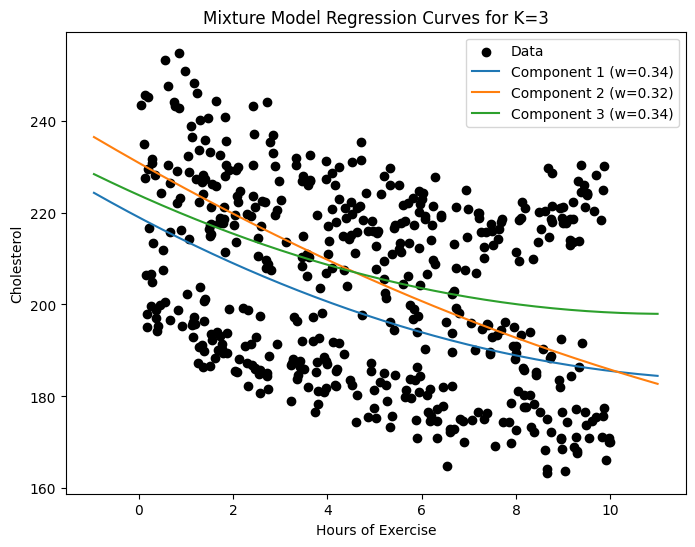

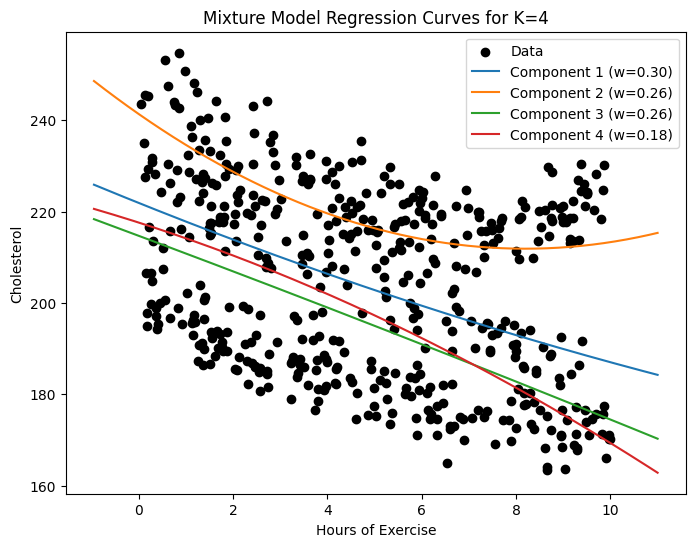

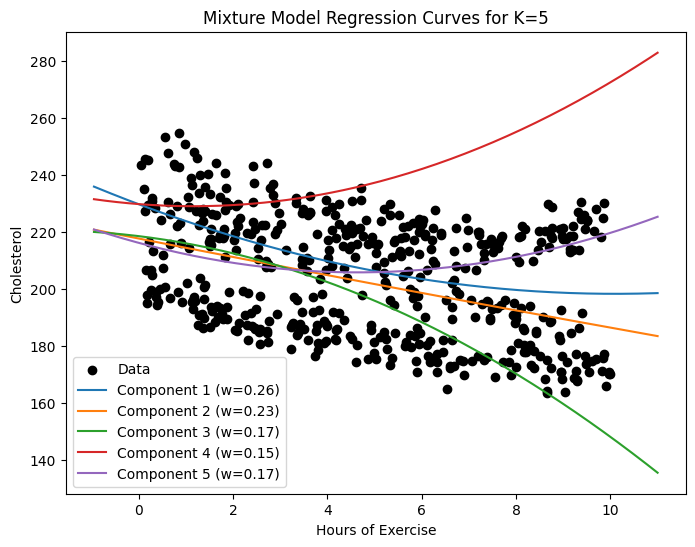

In [7]:
for k in [3, 4, 5]:
    plot_mixture_curves(x, y, traces[k], k)